# Global Imports

In [1]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from einops import rearrange
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn
from typing import Any
import glob
import re
from datetime import datetime
import random
from collections import defaultdict
from collections import Counter
random.seed(42)

# Local Imports

In [2]:
from training.train import EpochLogs, grid_search, LogPoint
from dataset.character_dataset import CharImageDataset
from models.allcnn2d import AllCNN2D

# Globals

In [3]:
DATASET_SPLIT: float = 0.8
MODEL_NAME: str = "z_BadapplePie"
LOAD_CHECKPOINT: str = r"C:\Users\Leon\visual-studio\repos\Le-o-n\ocr-model-training\models\allcnn\z_ApplePie_epoch43_trainacc0.85371_valacc0.78599_Tloss0.027453_Vloss0.050662_lr0.0007224.pkl"

# Define Paths
Workspace

In [4]:
notebook_dir: str = os.path.abspath(".")
root_dir: str = os.path.join(
    notebook_dir,
    os.pardir,
    os.pardir
)

data_dir: str = r"C:\Users\Leon\visual-studio\repos\Le-o-n\ocr-model-training\data\alphanum\val_p_train\fix"

model_save_dirpath: str = os.path.join(
    root_dir,
    "models",
    "allcnn"
)

Image paths

In [5]:

images_path_glob: str = os.path.join(
    data_dir,
    "u*.*"
)
images_path_regex: str = r"(u[0-9a-f]+)-([0-9a-zA-Z]+)\.[(jpgpng)+]"

image_paths: list[str] = glob.glob(images_path_glob)
random.shuffle(image_paths)



# Helper Functions

In [6]:
def get_current_time() -> str:
    return datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

# Logging Setup 

In [7]:

logging_path: str = f"{MODEL_NAME}_log_{get_current_time()}.csv"

with open(logging_path, "w") as f:
    f.write("TIME,EPOCH,TRAIN_ACC,VAL_ACC,TRAIN_LOSS,VAL_LOSS,LR\n")


def log(
    epoch: int,
    train_acc: float,
    train_loss: float,
    val_acc: float,
    val_loss,
    lr: float
) -> None:
    with open(logging_path, "a") as f:
        f.write(f"{get_current_time()},{epoch},{train_acc},{val_acc},{train_loss},{val_loss},{lr}\n")

# Extract Labels From File Names

In [8]:


labeled_image_paths: list[tuple[str, str]] = []

class_counts: dict[str, int] = defaultdict(lambda: 0)

file_path: str
for file_path in image_paths:
    match = re.search(images_path_regex, file_path)

    if not match:
        continue

    u_hexvalue: str = match.group(1)

    class_counts[u_hexvalue] += 1

    labeled_image_paths.append((u_hexvalue, file_path))

labels: list[str]
image_paths: list[str]
labels, image_paths = list(zip(*labeled_image_paths))

len(labels), len(image_paths)

(61954, 61954)

In [9]:
Counter(labels)

Counter({'u31': 2194,
         'u36': 1827,
         'u30': 1734,
         'u39': 1693,
         'u34': 1639,
         'u38': 1599,
         'u69': 1597,
         'u33': 1540,
         'u37': 1491,
         'u35': 1489,
         'u32': 1450,
         'u65': 1429,
         'u41': 1409,
         'u74': 1298,
         'u4f': 1223,
         'u45': 1179,
         'u6c': 1117,
         'u4e': 1092,
         'u61': 1090,
         'u53': 1062,
         'u52': 1061,
         'u4c': 1055,
         'u49': 1052,
         'u43': 1029,
         'u6e': 992,
         'u50': 988,
         'u48': 951,
         'u6f': 934,
         'u4a': 906,
         'u47': 889,
         'u4d': 882,
         'u72': 868,
         'u64': 858,
         'u51': 841,
         'u73': 824,
         'u42': 820,
         'u44': 815,
         'u59': 803,
         'u4b': 799,
         'u55': 791,
         'u57': 751,
         'u54': 714,
         'u58': 694,
         'u46': 639,
         'u5a': 631,
         'u75': 610,
         '

# Balance Classes Using Oversample/Undersample

In [10]:
sorted_counts: list[tuple[str, int]] = sorted(
    class_counts.items(),
    key=lambda x: x[0]
)

counts: list[int] = [pair[1] for pair in sorted_counts]

max_count: int = max(counts)
min_count: int = min(counts)

to_add_counts: dict[str, int] = {
    uid: max_count - count
    for uid, count in
    sorted_counts
}

to_undersample_counts: dict[str, int] = {
    uid: min_count
    for uid, count in
    sorted_counts
}

total_items = sum(x[1] for x in sorted_counts)

In [11]:
min_count, max_count, total_items

(41, 2194, 61954)

In [12]:
# print(*to_add_counts.items())
# print(sorted([(chr(int(pair[0][1:], 16)), pair[1]) for pair in to_remove_counts.items()], key=lambda x: x[1]))

# Oversample

In [13]:
# to_add_labels: list[str] = []
# to_add_file_paths: list[str] = []
#
# while True in [to_add_count>0 for to_add_count in to_add_counts.values()]:
#    for label, image_path in zip(labels, image_paths):
#        remaining: int = to_add_counts[label]
#
#        if remaining > 0:
#            to_add_labels.append(label)
#            to_add_file_paths.append(image_path)
#            to_add_counts[label] -= 1

# Undersample

In [14]:
to_keep_labels: list[str] = []
to_keep_file_paths: list[str] = []

while True in [to_add_count > 0 for to_add_count in to_undersample_counts.values()]:
    for label, image_path in zip(labels, image_paths):
        remaining: int = to_undersample_counts[label]

        if remaining > 0:
            to_keep_labels.append(label)
            to_keep_file_paths.append(image_path)
            to_undersample_counts[label] -= 1

In [15]:
to_keep_labels

['u4e',
 'u61',
 'u4f',
 'u2a',
 'u68',
 'u2d',
 'u48',
 'u6f',
 'u32',
 'u4a',
 'u35',
 'u38',
 'u72',
 'u37',
 'u70',
 'u73',
 'u73',
 'u4c',
 'u33',
 'u61',
 'u49',
 'u59',
 'u54',
 'u48',
 'u58',
 'u44',
 'u52',
 'u6c',
 'u37',
 'u72',
 'u5a',
 'u61',
 'u52',
 'u65',
 'u52',
 'u4b',
 'u52',
 'u31',
 'u3d',
 'u62',
 'u5a',
 'u5d',
 'u52',
 'u33',
 'u6c',
 'u70',
 'u4d',
 'u64',
 'u4a',
 'u74',
 'u37',
 'u52',
 'u30',
 'u46',
 'u6c',
 'u6c',
 'u42',
 'u50',
 'u4c',
 'u65',
 'u32',
 'u58',
 'u39',
 'u46',
 'u49',
 'u49',
 'u50',
 'u44',
 'u5c',
 'u49',
 'u36',
 'u53',
 'u35',
 'u6e',
 'u41',
 'u33',
 'u4e',
 'u70',
 'u43',
 'u61',
 'u49',
 'u48',
 'u24',
 'u4f',
 'u48',
 'u35',
 'u36',
 'u77',
 'u37',
 'u79',
 'u4b',
 'u52',
 'u79',
 'u34',
 'u6d',
 'u6c',
 'u52',
 'u55',
 'u4b',
 'u50',
 'u76',
 'u4d',
 'u36',
 'u6b',
 'u39',
 'u31',
 'u5a',
 'u39',
 'u29',
 'u43',
 'u62',
 'u73',
 'u51',
 'u51',
 'u5a',
 'u50',
 'u39',
 'u4f',
 'u51',
 'u38',
 'u4b',
 'u53',
 'u77',
 'u64',
 'u47',


In [16]:

Counter(to_keep_labels)

Counter({'u4e': 41,
         'u61': 41,
         'u4f': 41,
         'u2a': 41,
         'u68': 41,
         'u2d': 41,
         'u48': 41,
         'u6f': 41,
         'u32': 41,
         'u4a': 41,
         'u35': 41,
         'u38': 41,
         'u72': 41,
         'u37': 41,
         'u70': 41,
         'u73': 41,
         'u4c': 41,
         'u33': 41,
         'u49': 41,
         'u59': 41,
         'u54': 41,
         'u58': 41,
         'u44': 41,
         'u52': 41,
         'u6c': 41,
         'u5a': 41,
         'u65': 41,
         'u4b': 41,
         'u31': 41,
         'u3d': 41,
         'u62': 41,
         'u5d': 41,
         'u4d': 41,
         'u64': 41,
         'u74': 41,
         'u30': 41,
         'u46': 41,
         'u42': 41,
         'u50': 41,
         'u39': 41,
         'u5c': 41,
         'u36': 41,
         'u53': 41,
         'u6e': 41,
         'u41': 41,
         'u43': 41,
         'u24': 41,
         'u77': 41,
         'u79': 41,
         'u34': 41,


# Load Dataset

In [17]:
image_paths = to_keep_file_paths
labels = to_keep_labels
len(image_paths), len(labels)

(3854, 3854)

In [18]:
from sklearn.model_selection import train_test_split

# image_paths: list of file paths
# labels: list of corresponding string labels

train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths,
    labels,
    test_size=0.2,           # 20% for validation
    stratify=labels,         # stratified by label
    random_state=42          # for reproducibility
)


all_label_classes: list[str] = sorted(list(set(labels)))

In [19]:
"".join(list(map(lambda x: chr(int(x[1:], 16)), all_label_classes)))

'!"#$%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~'

In [20]:

train_char_dataset: CharImageDataset = CharImageDataset(
    file_paths=train_paths,  # list(image_paths[:split_index]) + to_add_file_paths,
    labels=train_labels,  # list(labels[:split_index]) + to_add_labels,
    all_label_classes=all_label_classes,
    rotation_limit=0.05,
    translation_limit=0.2,
    skew_limit=0.03,
    zoom_change=1.2,
    min_zoom=0.8,
    thicken_sigma=-3.75,
    image_dims=(64, 64)
)

val_char_dataset: CharImageDataset = CharImageDataset(
    file_paths=val_paths,
    labels=val_labels,
    all_label_classes=all_label_classes,
    rotation_limit=0.0,
    translation_limit=0.0,
    skew_limit=0.00,
    zoom_change=0.0,
    min_zoom=1.0,
    thicken_sigma=0.0,
    image_dims=(64, 64)
)

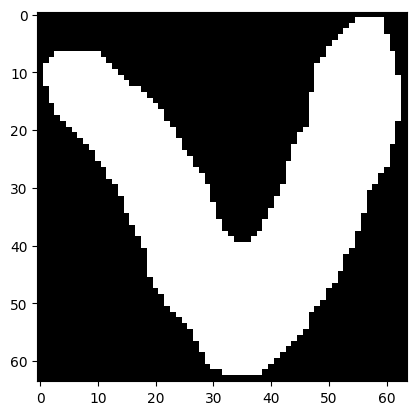

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])


In [21]:
for im, lab in train_char_dataset:
    plt.imshow(
        rearrange(im, "1 h w -> h w")*255,
        cmap="gray"
    )
    plt.show()

    print(lab)
    break

torch.Size([1, 64, 64])


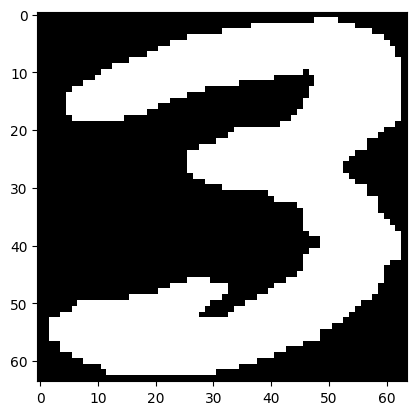

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])


In [22]:
for im, lab in val_char_dataset:
    print(im.shape)
    plt.imshow(rearrange(im, "1 h w -> h w")*255, cmap="gray")
    plt.show()
    print(lab)
    break

# Load DataLoader

In [23]:
train_dataloader: DataLoader = DataLoader(
    train_char_dataset,
    shuffle=True,
    batch_size=16
)

val_dataloader: DataLoader = DataLoader(
    val_char_dataset,
    shuffle=False,
    batch_size=16
)

In [24]:
len(class_counts.keys())

94

# Define Model Hyperparameters

In [25]:


all_model_parameters: list[dict[str, Any]] = [
    {
        "conv_features": (1, 16, 32, 32, 64),
        "fully_connected_features": (256, len(all_label_classes)),
        "expected_input_size": (64, 64),
        "device": "cuda",
        "conv_dropout": 0.15,
        "verbose": True,
        "name_prefix": MODEL_NAME,
        "checkpoint_path": LOAD_CHECKPOINT
    }
]

all_optim_parameters: list[dict[str, Any]] = [
    {
        "lr": 0.0007224,
        "weight_decay": 1
    }
]

AllCNN2D(**all_model_parameters[0])
pass

Loaded: encoder_conv_blocks.0.0.weight
Loaded: encoder_conv_blocks.0.0.bias
Loaded: encoder_conv_blocks.0.2.weight
Loaded: encoder_conv_blocks.0.2.bias
Loaded: encoder_conv_blocks.0.2.running_mean
Loaded: encoder_conv_blocks.0.2.running_var
Loaded: encoder_conv_blocks.0.2.num_batches_tracked
Loaded: encoder_conv_blocks.0.4.weight
Loaded: encoder_conv_blocks.0.4.bias
Loaded: encoder_conv_blocks.0.6.weight
Loaded: encoder_conv_blocks.0.6.bias
Loaded: encoder_conv_blocks.0.6.running_mean
Loaded: encoder_conv_blocks.0.6.running_var
Loaded: encoder_conv_blocks.0.6.num_batches_tracked
Loaded: encoder_conv_blocks.1.0.weight
Loaded: encoder_conv_blocks.1.0.bias
Loaded: encoder_conv_blocks.1.2.weight
Loaded: encoder_conv_blocks.1.2.bias
Loaded: encoder_conv_blocks.1.2.running_mean
Loaded: encoder_conv_blocks.1.2.running_var
Loaded: encoder_conv_blocks.1.2.num_batches_tracked
Loaded: encoder_conv_blocks.1.4.weight
Loaded: encoder_conv_blocks.1.4.bias
Loaded: encoder_conv_blocks.1.6.weight
Loaded

# Train

In [26]:
from IPython.display import clear_output

epoch_log: EpochLogs
for epoch_log in grid_search(
    model_factory=AllCNN2D,
    all_model_parameters=all_model_parameters,
    optim_factory=AdamW,
    all_optim_params=all_optim_parameters,
    epochs=10000,
    criterion=nn.CrossEntropyLoss(),
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    lr_decay_window_size=10,
    lr_decay_minimum=0.0,
    scheduler_scale=0.85,
    device="cuda"
):
    
    
    clear_output()
    train_logpoints: list[LogPoint] = epoch_log.train_logs
    val_logpoints: list[LogPoint] = epoch_log.val_logs

    train_count: int = 0
    val_count: int = 0

    train_losses_tally: float = 0.0
    val_losses_tally: float = 0.0

    train_correct_tally: int = 0
    val_correct_tally: int = 0

    for log_point in train_logpoints:

        y_hat_pred: torch.Tensor = torch.argmax(
            log_point.y_hat,
            axis=-1
        ).detach().cpu()

        y_pred: torch.Tensor = torch.argmax(
            log_point.y, axis=-1
        ).detach().cpu()

        train_is_correct = y_hat_pred == y_pred
        train_correct_tally += torch.sum(train_is_correct)

        train_losses_tally += torch.sum(log_point.loss)

        train_count += len(y_hat_pred)

    for log_point in val_logpoints:

        y_hat_pred: torch.Tensor = torch.argmax(
            log_point.y_hat,
            axis=-1
        ).detach().cpu()

        y_pred: torch.Tensor = torch.argmax(
            log_point.y, axis=-1
        ).detach().cpu()
        #print(y_hat_pred, y_pred)
        val_correct_tally += torch.sum(y_hat_pred == y_pred)

        val_losses_tally += torch.sum(log_point.loss)

        val_count += len(y_hat_pred)

    train_accuracy: float = train_correct_tally/train_count
    val_accuracy: float = val_correct_tally/val_count if val_count > 0 else 0.0

    train_loss: float = train_losses_tally/train_count
    val_loss: float = val_losses_tally/val_count if val_count > 0 else 0.0

    cur_learning_rate: float = epoch_log.optimiser.param_groups[0]["lr"]

    model_checkpoint_path: str = os.path.join(
        model_save_dirpath,
        f"{MODEL_NAME}_epoch{epoch_log.epoch}_trainacc{train_accuracy:.5}_valacc{val_accuracy:.5}_Tloss{train_loss:.5}_Vloss{val_loss:.5}_lr{cur_learning_rate}.pkl"
    )

    with open(model_checkpoint_path, "wb") as f:
        torch.save(epoch_log.model.state_dict(), f)

    print(f"Train Accuracy      : {train_accuracy}")
    print(f"Val Accuracy        : {val_accuracy}")
    print(f"Loss                : {train_loss}")
    print(f"Val Loss            : {val_loss}")
    print(f"Learning Rate       : {cur_learning_rate}")

    log(
        epoch_log.epoch,
        train_accuracy,
        train_loss,
        val_accuracy,
        val_loss,
        cur_learning_rate
    )

Train Accuracy      : 0.6535841822624207
Val Accuracy        : 0.686121940612793
Loss                : 0.0751764178276062
Val Loss            : 0.06670589745044708
Learning Rate       : 0.0006140399999999999


Training model...:  63%|██████▎   | 122/193 [00:22<00:12,  5.50it/s]


KeyboardInterrupt: 

# Inference

In [ ]:
model: AllCNN2D = AllCNN2D(
    **{
        "conv_features": (1, 16, 32, 32, 32, 32),
        "fully_connected_features": (64, 44),
        "expected_input_size": (64, 64),
        "device": "cuda",
        "conv_dropout": 0.0,  # 0.075,
        "verbose": True,
        "name_prefix": MODEL_NAME,
        "checkpoint_path": r"C:\Users\Leon\visual-studio\repos\Le-o-n\ocr-model-training\models\allcnn\Indigo_epoch26_trainacc0.71327_valacc0.99057_Tloss0.072851_Vloss0.0056362_lr0.0007224999999999999.pkl"
    }
)

Loaded: encoder_conv_blocks.0.0.weight
Loaded: encoder_conv_blocks.0.0.bias
Loaded: encoder_conv_blocks.0.2.weight
Loaded: encoder_conv_blocks.0.2.bias
Loaded: encoder_conv_blocks.0.2.running_mean
Loaded: encoder_conv_blocks.0.2.running_var
Loaded: encoder_conv_blocks.0.2.num_batches_tracked
Loaded: encoder_conv_blocks.0.4.weight
Loaded: encoder_conv_blocks.0.4.bias
Loaded: encoder_conv_blocks.0.6.weight
Loaded: encoder_conv_blocks.0.6.bias
Loaded: encoder_conv_blocks.0.6.running_mean
Loaded: encoder_conv_blocks.0.6.running_var
Loaded: encoder_conv_blocks.0.6.num_batches_tracked
Loaded: encoder_conv_blocks.1.0.weight
Loaded: encoder_conv_blocks.1.0.bias
Loaded: encoder_conv_blocks.1.2.weight
Loaded: encoder_conv_blocks.1.2.bias
Loaded: encoder_conv_blocks.1.2.running_mean
Loaded: encoder_conv_blocks.1.2.running_var
Loaded: encoder_conv_blocks.1.2.num_batches_tracked
Loaded: encoder_conv_blocks.1.4.weight
Loaded: encoder_conv_blocks.1.4.bias
Loaded: encoder_conv_blocks.1.6.weight
Loaded

In [ ]:
for char, label in val_char_dataset:
    plt.imshow(char[0, :, :])
    plt.show()
    pred: torch.Tensor = model.forward(char.unsqueeze(0)).squeeze()
    pred_index: int = torch.argmax(pred).item()
    print(chr(int(all_label_classes[pred_index][1:], base=16)))

TypeError: pad() got an unexpected keyword argument 'mode'